## BM25

### BM25 Hard Code Implementation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import json
from tqdm import tqdm
import pickle
import os

### NLTK Preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


"""
-----------------------------------------------------------------------------------------
Document indexes
-----------------------------------------------------------------------------------------
"""
def create_doc_index(corpus):
    """Creates doc index"""

    doc_ind = {}
    for i,doc in enumerate(corpus):
        doc_ID = "doc" + str(i)
        doc_ind[doc_ID] = doc

    return doc_ind

def create_doc_map(corpus):
    """creates dict mapping doc to integer"""

    doc_map={}
    for i,doc in enumerate(corpus):
        doc_map[i] = doc
    return doc_map

"""
Inverted dict lookup
"""
def get_key(dict, val):
    for key, value in dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

"""
-----------------------------------------------------------------------------------------
Term indexes
-----------------------------------------------------------------------------------------
"""
def create_vocab(corpus):
    """creates vocabulary of unique words in corpus"""

    vocab = []
    for doc in corpus:
        for sent in doc:
            for w in sent:
                if w not in vocab:
                    vocab.append(w)

    return vocab

def create_term_index(vocab):
    """creates term index mapping each term to an integer"""

    term_index={}
    for i,word in enumerate(vocab):
        term_index[word] = i

    return term_index


"""
-----------------------------------------------------------------------------------------
Building TD matrix
-----------------------------------------------------------------------------------------
"""
def fast_td(corpus, vocab):
    """ basically fast td array """

    total_terms = len(vocab)
    total_docs = len(corpus)
    td_matrix = np.zeros((total_terms, total_docs))
    doc_map = create_doc_map(corpus)
    term_map = create_term_index(vocab)

    for doc in corpus:
        j = get_key(doc_map, doc)
        for sent in doc:
            for word in sent:
                if word in vocab:
                    i = term_map[word]
                    td_matrix[i,j]+=1   

    return td_matrix 

In [2]:
"""
-----------------------------------------------------------------------------------------
Building BM25 matrix
-----------------------------------------------------------------------------------------
"""
def create_doc_lengths(corpus):
  """ list of doc lens """
  doc_lengths = []
  for doc in corpus:
    flattened_doc = list(flatten(doc))
    doc_len = len(flattened_doc)
    doc_lengths.append(doc_len)

  return doc_lengths

def cal_L_avg(doc_lengths):
  """ calculate average length of documents """
  L_avg = sum(doc_lengths)/len(doc_lengths)
  return L_avg


def bm25_matrix(corpus, k1, b):
  """
  creates bm matrix from given corpus with terms as rows and documents as columns
  returns bm25 matrix with each term-doc element weighted by it's BM25 measure
  """

  corpus = corpus
  vocab = create_vocab(corpus)
  doc_lengths = create_doc_lengths(corpus)
  total_docs = len(doc_lengths)
  L_avg = cal_L_avg(doc_lengths)
  td_array = fast_td(corpus, vocab)
  bm25_matrix = np.zeros(td_array.shape)

  for i in list(range(td_array.shape[0])):
    for j in list(range(td_array.shape[1])):
      bm25_matrix[i,j] = td_array[i,j]*(k1 + 1)/(td_array[i,j] + k1*(1-b + b*(doc_lengths[j]/L_avg)))
  
  ni = np.sum((td_array > 0), axis=1)
  term_idf = np.zeros(ni.shape)
  for i,ni in enumerate(list(ni)):
    term_idf[i] = np.log10((total_docs - ni + 0.5)/(ni + 0.5) + 1)
    

  bm25_matrix = np.multiply(bm25_matrix, term_idf.reshape(-1,1))
  return bm25_matrix

In [3]:
"""
-----------------------------------------------------------------------------------------
Query processing
-----------------------------------------------------------------------------------------
"""
def create_query_index(corpus):
    """Creates query index"""

    query_ind = {}
    for i,query in enumerate(corpus):
        query_ID = "query" + str(i)
        query_ind[query_ID] = query

    return query_ind

def query_proc(query_corp, doc_vocab):
    """accepts queries as lists of lists - treated like documents """

    query_ind = create_query_index(query_corp) ### {q0 - [[]], q1 - [[]]} type of indexing
    query_td_arr = fast_td(query_corp, doc_vocab)
    # query_tfidf = np.multiply(query_td_arr, term_idf.reshape(-1,1))

    return query_td_arr, query_ind


"""
-----------------------------------------------------------------------------------------
Ranking
-----------------------------------------------------------------------------------------
"""
def ranking(query_tf, bm25_matrix, k):
    """produces the top k relevant documents per query"""  

    """Ranking by cosine sim and argsort, then picking top 3 relevant docs"""    
    cosine_sim_matrix = query_tf.T@bm25_matrix
    ind = np.argsort(cosine_sim_matrix, axis=1)
    
    best_match = np.fliplr(ind[:, -k:])
    ind_list = best_match.tolist()

    return ind_list

In [ ]:
from native_preprocessor import native_prep
native_prep = native_prep()

def load_json_files():
    # Read queries
    queries_json = json.load(open(main_path + "cran_queries.json", 'r'))[:]
    query_ids, queries = [item["query number"] for item in queries_json], \
                            [item["query"] for item in queries_json]
    # Process queries 
    # print(queries)
    processedQueries = native_prep.preprocessQueries(queries)

    processedQueries = processedQueries[:]
    # print(processedQueries)

    # Read documents
    docs_json = json.load(open(main_path + "cran_docs.json", 'r'))[:]
    doc_ids, docs = [item["id"] for item in docs_json], \
                            [item["body"] for item in docs_json]
    # Process documents
    processedDocs = native_prep.preprocessDocs(docs)
    # print(processedDocs[0])

    ### to resolve num1 discrepancy:
    query_ids = list(np.array(query_ids)-1)
    doc_ids = list(np.array(doc_ids)-1)    
    return processedQueries, processedDocs, query_ids, doc_ids

proc_queries, proc_docs, query_ids, doc_ids = load_json_files()


def searchDataset(processedQueries, processedDocs, k):
    """
    - preprocesses the queries and documents, stores in output folder
    - invokes the IR system
    - evaluates precision, recall, fscore, nDCG and MAP 
        for all queries in the Cranfield dataset
    - produces graphs of the evaluation metrics in the output folder
    """
    
    doc_index = create_doc_index(processedDocs)
    # print(herb_doc_index)
    # herb_term_index = create_term_index(processedDocs) 
    # print(herb_term_index)
    doc_vocab = create_vocab(processedDocs)
    # print(herb_vocab)
    doc_bm25 = bm25_matrix(processedDocs, 1.5, 0.75)
    # print(herb_tfidf_mat[:20, :20])
    query_tf, query_index = query_proc(processedQueries, doc_vocab)
    # print(herb_query_tfidf.sum())
    doc_best = ranking(query_tf, doc_bm25, k)
    return doc_best

doc_ids_ordered = searchDataset(proc_queries, proc_docs, 10)
# print(doc_ids_ordered)


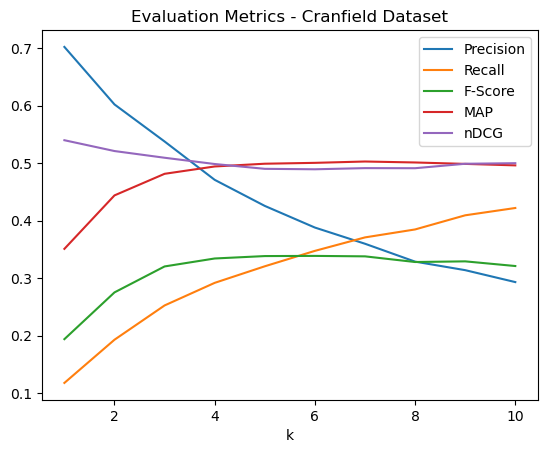

In [8]:
qrels = json.load(open(main_path + "cran_qrels.json", 'r'))[:]

from big_true_IDs import big_true_IDs
big_true_IDs_ob = big_true_IDs()
big_true_IDs = big_true_IDs_ob.big_true_IDs(qrels)  

query_ids = list(range(225))

from plotting import plotting
plot_ob = plotting()
plot_ob.plot_measures(doc_ids_ordered, query_ids, big_true_IDs, qrels, 11)

In [6]:
# query_index = create_query_index(proc_queries)
# doc_index = create_doc_index(proc_docs)
# query_num_list = list(range(225))

from check_matches import Check_matches
check_matches = Check_matches()

bqi = check_matches.check_queries(doc_ids_ordered, query_ids, big_true_IDs, qrels, 10)
print("------------------------------------------------")
print("Number of queries with 0 precision - ", len(bqi))
print("Query IDs - ", bqi)
print("------------------------------------------------")
query_index = check_matches.create_query_index(proc_queries)
doc_index = check_matches.create_doc_index(proc_docs)
check_matches.display_query_match(bqi, query_index, doc_ids_ordered, doc_index)

------------------------------------------------
Number of queries with 0 precision -  16
Query IDs -  [8, 21, 27, 34, 43, 61, 62, 63, 108, 109, 115, 150, 151, 206, 215, 218]
------------------------------------------------
for query_num =  8

query :  [['paper', 'internal', '/slip', 'flow/', 'heat', 'transfer', 'study']]

------------------------------------------------------------------------------------
rank 1 : doc485

[['similarity', 'law', 'aerothermoelastic', 'testing'], ['similarity', 'law', 'aerothermoelastic', 'testing', 'presented', 'range'], ['obtained', 'making', 'nondimensional', 'appropriate', 'governing', 'equation', 'individual', 'external', 'aerodynamic', 'flow', 'heat', 'conduction', 'interior', 'stress-deflection', 'problem', 'make', 'combined', 'aerothermoelastic', 'problem'], ['general', 'aerothermoelastic', 'model', 'model', 'placed', 'high-stagnation-temperature', 'wind', 'tunnel', 'similitude', 'shown', 'difficult', 'achieve', 'scale', 'ratio', 'unity'], ['prim

Text(0, 0.5, 'Length of documents')

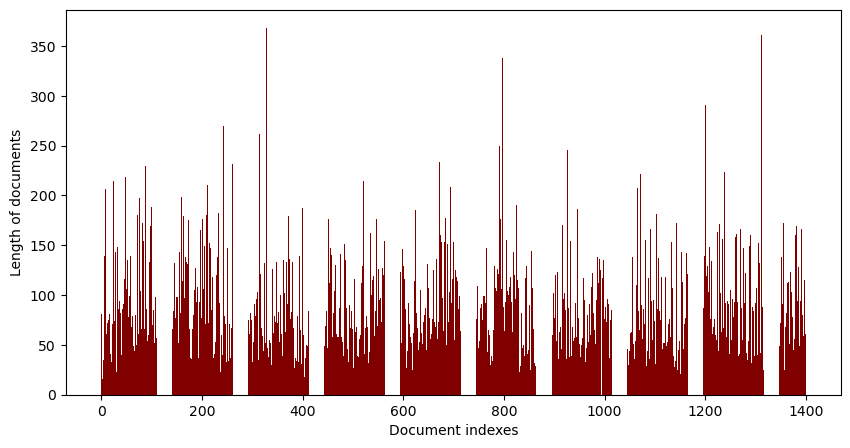

In [7]:
"""
-----------------------------------------------------------------------------------------
Document length imbalance
-----------------------------------------------------------------------------------------
"""
doc_lengths = create_doc_lengths(proc_docs)
 
# creating the bar plot
fig = plt.figure(figsize = (10,5))
plt.bar(list(range(1400)), doc_lengths, color ='maroon') 
plt.xlabel("Document indexes")
plt.ylabel("Length of documents")
